### Установка

In [1]:
pip install torch

In [2]:
pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.8 MB/s eta 0:00:00


In [14]:
pip install accelerate

In [1]:
import torch
import numpy as np

from diffusers import KandinskyV22PriorEmb2EmbPipeline, KandinskyV22ControlnetImg2ImgPipeline
from diffusers.utils import load_image
from transformers import pipeline

In [11]:
import gc
gc.collect()

26014

In [2]:
img = load_image(
   "image2.png"
#"https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main" "/kandinskyv22/cat.png"
).resize((768, 768))

In [3]:
def make_hint(image, depth_estimator):
    image = depth_estimator(image)["depth"]
    image = np.array(image)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    detected_map = torch.from_numpy(image).float() / 255.0
    hint = detected_map.permute(2, 0, 1)
    return hint

In [4]:
pipe_prior = KandinskyV22PriorEmb2EmbPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
depth_estimator = pipeline("depth-estimation")
hint = make_hint(img, depth_estimator).unsqueeze(0).half().to("cuda")

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [6]:
pipe_prior = pipe_prior.to("cuda")

In [7]:
pipe = KandinskyV22ControlnetImg2ImgPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-controlnet-depth", torch_dtype=torch.float16
)

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
pipe = pipe.to("cuda")

In [31]:
prompt = "A photo-realistic rendering of a busy market, ((street vendors, fruits, vegetable, shops))"
negative_prior_prompt = "ugly, disfigured, low quality, blurry, nsfw, watermark, text"


In [10]:
generator = torch.Generator(device="cuda").manual_seed(43)

In [32]:
# run prior pipeline
img_emb = pipe_prior(prompt=prompt, image=img, strength=0.85, generator=generator)
negative_emb = pipe_prior(prompt=negative_prior_prompt, image=img, strength=1, generator=generator)

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [42]:
# run controlnet img2img pipeline
images = pipe(
    image=img,
    strength=0.35,
    image_embeds=img_emb.image_embeds,
    negative_image_embeds=negative_emb.image_embeds,
    hint=hint,
    num_inference_steps=11,
    generator=generator,
    height=768,
    width=768,
).images
#768x768
images[0].save("result.png")

  0%|          | 0/3 [00:00<?, ?it/s]

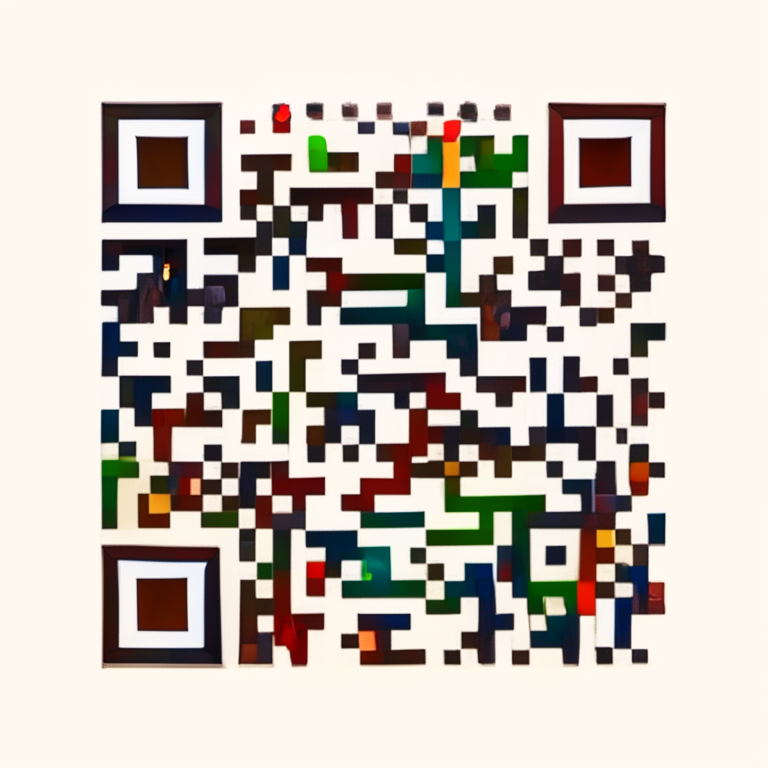

In [43]:
images[0]

In [14]:
import cv2

In [15]:
def scan(FILE_NAME):
    qcd = cv2.QRCodeDetector()
    img = cv2.imread(FILE_NAME)
    retval, decoded_info, points, straight_qrcode = qcd.detectAndDecodeMulti(img)
    return retval, decoded_info, points, straight_qrcode

In [44]:
# Расшифрованный QR-код (можно добавить ещё проверок):
scan("result.png")

(True,
 ('https://s00.yaplakal.com/pics/pics_preview/3/2/8/17751823.jpg',),
 array([[[101.     , 103.     ],
         [664.     , 103.     ],
         [664.7527 , 663.72003],
         [103.     , 667.     ]]], dtype=float32),
 (array([[  0,   0,   0, ...,   0,   0,   0],
         [  0, 255, 255, ..., 255, 255,   0],
         [  0, 255,   0, ...,   0, 255,   0],
         ...,
         [  0, 255,   0, ...,   0, 255, 255],
         [  0, 255, 255, ...,   0, 255, 255],
         [  0,   0,   0, ..., 255,   0, 255]], dtype=uint8),))